In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

path = os.getcwd()

# Trupanion Data Scientist Skill Assessment

In [2]:
labels = pd.read_csv(path+'/data/p1_labels.csv')
# print("\nLabels has {} unique amt_labels".format(len(labels.amt_labeled.unique())))
# print("Labels has {} unique Claim Id's\n".format(len(labels.ClaimId.unique())))

items = pd.read_csv(path+'/data/p1_lineitems.csv')
# print("\nItems has {} unique amt_lineitem".format(len(items.amt_lineitem.unique())))
# print("Items has {} unique Claim Id's\n".format(len(items.ClaimId.unique())))

In [3]:
labels.head(2)

,ClaimId,id_labeled,amt_labeled
0,1,1,301.54
1,1,2,105.00


In [4]:
items.head(2)

,ClaimId,id_lineitem,amt_lineitem,features
0,1,1,105.00,x
1,1,2,105.94,x


---
## Part 1 – Preparing a usable dataset

- When we receive invoice data from our customers, it is structured by line item. 
- Trupanion then aggregates one or many line items to a higher level category for payment or denial. 
- One of our end goals is to automate this line item grouping by categorizing each invoice line item. 
- In order to do so, we must essentially undo that aggregation, so you must first map each line item to the appropriate group. 
- Our labels (in file ...labels) must be linked to our features (in file ...lineitems).

Use the files named p1_labels.csv and p1_lineitems.csv to map as many line item data ids to labeled ids as possible.
Hints:
- “ClaimId” is a common index shared between the csvs
- The expected solution is a list of mappings from id_lineitem to id_labeled
- Not all line item data ids can be mapped
- Submit your work alongside your solution
    - We typically use python/jupyter notebook, but any similar language or tool is acceptable 
- I’ve included a “features” column as a reminder of our end goal – nothing needs to be done with it

In [5]:
# Merge by ClaimID, If there is no match, the missing side will contain null. 

df = pd.merge(items, labels, on='ClaimId', how='outer')
print(df.shape,"\nThere were {} records not matched from the data table".format(df.isnull().sum().features))
df.loc[df.id_lineitem.isnull()]

(30930, 6) 
There were 9 records not matched from the data table


,ClaimId,id_lineitem,amt_lineitem,features,id_labeled,amt_labeled
30921,190,NaN,NaN,NaN,425,0.00
30922,821,NaN,NaN,NaN,1633,0.00
30923,1413,NaN,NaN,NaN,2753,0.00
30924,1669,NaN,NaN,NaN,3217,0.00
30925,1868,NaN,NaN,NaN,3597,94.28
30926,1868,NaN,NaN,NaN,3598,50.92
30927,1893,NaN,NaN,NaN,3645,0.00
30928,1898,NaN,NaN,NaN,3656,0.00
30929,2209,NaN,NaN,NaN,4214,0.00


In [6]:
# Lets remove them for now

df = pd.merge(items, labels, on='ClaimId', how='inner')
print(df.shape)
df.head()

(30921, 6)


,ClaimId,id_lineitem,amt_lineitem,features,id_labeled,amt_labeled
0,1,1,105.00,x,1,301.54
1,1,1,105.00,x,2,105.00
2,1,2,105.94,x,1,301.54
3,1,2,105.94,x,2,105.00
4,1,3,12.24,x,1,301.54


---
## Part 2 – Build a text classifier

Description:
- Our product does not cover routine, wellness or preventive care. 
- We believe that costs that pet owners can expect periodically and budget for should be separate from an insurance policy meant to cover accidents and illnesses.
- Use the data contained in p2_data.csv to build a binary classifier to predict the “PreventiveFlag” label using the text features provided. 
- This model can be used to automate the detection of ineligible line items. 
- The expected output are prediction probabilities for rows 10001 through 11000, where the labels are currently null.


#### This section is divided in:

1. Importing customized functions and Loading Data
2. Exploratory Data Analysis
3. Experiment Analysis
4. Definition of variables
5. Comparisson of the baseline vs tuned models
6. Training and Validation
7. Results
8. Prediction of the test set 
9. Conclusion

It is a sequential notebook (Each cell should to be run in order). However the 8th block (Prediction of the test set) can be run after blocks 1 and 4.   

Aside from this notebook and a python file with the functions used in this study, I've included 3 folders in this root folder: 
1. Data: Contains the given csv files. 
2. Graphics: Holds the images and graphs included in thiss study
3. Results: Has the predictions of the test set in a csv file along with another csv file with the experiments results. 

### 1. Load data

In [15]:
from myfunk import *

## --- Load Data
p2data = pd.read_csv(path+'/data/p2_data.csv', index_col = 0, encoding = "ISO-8859-1") #simplest text encoding

print("\nData has {} unique Diagnosis".format(len(p2data.Diagnosis.unique())))
print("Data has {} unique ItemDescriptions".format(len(p2data.ItemDescription.unique())))
print("Data has {} unique PreventiveFlags:{} \n {}".format(len(p2data.PreventiveFlag.unique()),
                                                           p2data.PreventiveFlag.unique(), 
                                                           p2data.PreventiveFlag.value_counts()))
# Is the data balanced? 
print("Data has {} null PreventiveFlags\n".format(p2data.PreventiveFlag.isnull().sum()))

# Divide training / testing datasets
test = p2data.loc[p2data.PreventiveFlag.isnull()]
data = p2data.loc[p2data.PreventiveFlag.notnull()]

print(data.shape, test.shape)
data.head(2)


Data has 2266 unique Diagnosis
Data has 10475 unique ItemDescriptions
Data has 3 unique PreventiveFlags:[ 0.  1. nan] 
 0.0    9322
1.0     678
Name: PreventiveFlag, dtype: int64
Data has 1000 null PreventiveFlags

(10000, 3) (1000, 3)


,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0


### 2. EDA

In [8]:
eda_stemming_lemmatizing(data.ItemDescription.apply(lambda word: text_analysis(word)), 
                         data.Diagnosis.apply(lambda word: text_analysis(word)))

There are 4541 different words, numbers and symbols in the Item Description
There are 2029 different words, numbers and symbols in the Diagnosis
There are 4431 different non-stop words and numbers in the Item Description
There are 1876 different non-stop words and numbers in the Item Description
There are 4300 different lemmas, numbers and symbols in the Item Description
There are 1731 different lemmas, numbers and symbols in the Diagnosis
There are 4127 different stems & numbers in the Item Description
There are 1631 different stems & numbers in the Diagnosis
There are 4129 different stems of lemmas & numbers in the Item Description
There are 1628 different stems of lemmas & numbers in the Diagnosis


#### Statistics for samples of class 1

```python
f, axarr = plt.subplots(2,3,figsize=(20,8))
stats_class(data, f, axarr, 1.0) 
f.savefig(path+'/graphics/class1_stats.png', dpi=f.dpi)
```
![**Figure. **](graphics/class1_stats.png)

#### Statistics for samples of class 0

```python
f, axarr = plt.subplots(2,3,figsize=(20,8))
stats_class(data, f, axarr, 0.0)
f.savefig(path+'/graphics/class0_stats.png', dpi=f.dpi)
```
![**Figure. **](graphics/class0_stats.png)
Class 0 Item descritpion fields have a normal like distribution. The diagnosis field however has a few outliers with a character length exceeding 200. Some with over more than 6 sentences and words above 50 count.

#### Statistics for the whole dataset
```python
f, axarr = plt.subplots(2,3,figsize=(20,8))
stats_overall(data, f, axarr)             
f.savefig(path+'/graphics/dataset_stats.png', dpi=f.dpi)
```
![**Figure. **](graphics/dataset_stats.png)

In [9]:
c0 = data.loc[data.PreventiveFlag==0.0]
c0d_lengths = [len(item[1].Diagnosis) for item in c0.iterrows()]
print(c0.iloc[np.where(np.array(c0d_lengths) > 200)].Diagnosis.shape)
outliers = c0.iloc[np.where(np.array(c0d_lengths) > 200)].index

(40,)


In [10]:
data = data.loc[~data.index.isin(outliers)]
data.shape

(9960, 3)

### 3. Experiment Analysis

As a preprocessing step the item descriptions and the diagnosis were blended and tokenized. I also remmoved some duplicated instances along with a couple of duplicated instances with different preventive flag values which I called contradictions and would act as noise for the classification. 
Another factor that wasn't relevant to the prediction was the pet name on the item's description. 

After text cleaning and removing stop words, there was over 6.3 thousand words to work with!

The next steps include feature engineering. I converted the text corpus to a matrix of token counts (using CountVectorizer), then transform a count matrix to a normalized tf-idf representation (with tf-idf transformer). I used as feature selection method the chi-square test since it measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

After that, I did a series of tests by training several classifiers from Scikit-Learn library (with default parameters)over different number of features, ngrams and the options of stemming (in this case), lemmatizing or both. The decision on whether to stem or not came from the fact that stemming gave higher performance scores. The training and validation splitting ratio was 70%:30% and the performance metric is the area under the curve (AUC) since it tells how much model is capable of distinguishing between classes and accuracy cannot show a reliable score due to the fact that the dataset is imbalanced. 

Python code to reproduce this figure:
```python
results = pd.read_csv(path+"/results/experimentation_results.csv", index_col=0)
fig = nGrams_distribution(results, 'Val', 5, 'AUC', 1)
fig.savefig(path+'/graphics/StemmingAUCdistributions.png', dpi=fig.dpi)
```
![**Figure. **](graphics/StemmingAUCdistributions.png)
The figure above shows the distribution of the performance score AUC of each of the classifiers. I divided the results by n-grams and by their dimensionality divided by 2 quartiles (low < 0.3, mid and high > 0.6). The 3rd column (showing the distributions with the number of features above 4000) doesn't show the distribution with 1-grams because the maximum number of 1-grams extracted from the training set was below the limit of 4000. However the number of combinations with 2-grams and 3-grams exceeded that limit. 

The random forest (RF) along with the SVM with gradient descent (SGD) perform best at low dimensions and 1-grams. The decision trees (DT) classifier outperforms them but its performance decreases as the dimensionality increases. 

The Gaussian NB (GNB) classifier, on the other hand, stabilizes around .858 (AUC score) and 2-grams as the number of dimensions increase. This clf also shows a competitive AUC score above 80%. 
As for the Adaboost classifier (AB), shows a high score in the low dimensions with the more n-grams the better. 

So there is a tradeoff between the number of features and the number of ngrams. The RF and SGD showing low performance (below 80%) must leave the race. The GNB performs better with higher dimensionality. AB performs better with higher n-grams and DT performs better with a low dimensionality and low ngrams. A balanced model with a set of these last 3 classifiers could have as parameters n-grams=2 and a mid-size dimensionality. 

Python code to reproduce this figure:
```python
# from sklearn import preprocessing
selected_baseline = ('DecisionTreeClassifier','GaussianNB','AdaBoostClassifier')

# cols = ['Phase','AUC', 'F1_C0', 'F1_C1', 'MSE', 'Prec_C0', 'Prec_C1', 'Recal_C0', 'Recal_C1','nFeats']
cols = ['Phase','AUC','nFeats']
res = results.loc[results.Phase.str.endswith(('DecisionTreeClassifier','GaussianNB','AdaBoostClassifier')),cols]\
            .groupby(['Phase','nFeats']).mean().reset_index()

cols = np.repeat(res.columns[2:].values,2)
fig, axes = plt.subplots(nrows = res.shape[1]-2, ncols = 2, figsize=(20,5*(res.shape[1]-2)))
plot_dimensionality_series(fig, axes, res, cols)
fig.savefig(path+'/graphics/auc_over_dimensions.png', dpi=fig.dpi)
```
![**Figure. **](graphics/auc_over_dimensions.png)
The figure (above) shows the AUC score over the number of features and the red line is a normalized sum of those scores. Since I chose the mid section of amount of features (2350-3850) the classifiers show a peak on ensemble score at 3100. I used this value as a reference to compare with the voting score of the remaining values of the number of features (nFeats)

The best nFeats value came out to be 3550. I did another test but this time with a training/validation split of 80%:20% (a rule of thumb) and the model yield a higher score for 4200 features.

---

### 4. Definition of Variables

In [16]:
## ---------------------
## --- Variables
## ---------------------
ng = 2                       # N gramms
lemaVsStem = 1               # [0 for Lemming, 1 for stemming, 2 for both, 5 for none]
k = 4200                     # Optimal number of features. 
seed = 42                    # To minimize the sampling variation. 
train_val_ratio = 0.2        # Rule of thumb (see Pareto principle)
resample_dataset = False     # Method to overcome the effect of an imbalanced dataset (Showed lower performance)
optimal_ratios = [1,1]       # Option2: [0.4,0.244]

np.random.seed(seed)


# Baseline classifiers: 
clf_base = {
    'clf_1':DecisionTreeClassifier(random_state=seed),
    'clf_2':AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), random_state=seed), 
    'clf_3':GaussianNB()}    


# Optimal baseline params: 
clf_opt = {
    'clf_1': DecisionTreeClassifier(max_depth=17,
             max_leaf_nodes=42,min_samples_split=12,random_state=seed), 
    'clf_2': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(max_depth=2,min_samples_split=2,random_state=seed),
           learning_rate=0.9, n_estimators=64, random_state=42), 
    'clf_3': GaussianNB()}


# Pipeline with Preprocessing functions and soft voting ensemble method
kbest = SelectKBest(chi2, k=4200) # Feature selection
sVoting = VotingClassifier(estimators=[(k,v) for k,v in clf_opt.items()], voting='soft')
mixed_pipe = Pipeline([('kbest', kbest), ('SoftVoting', sVoting)])


# Flags
flags = {'lemStem':lemaVsStem, 'optimalRatio':optimal_ratios,'resample': resample_dataset, 
         'trainValRatio': train_val_ratio,'n-grams': ng, 'N_Models':len(clf_opt),'rndseed':seed,
         'customVocabulary':False,'keepDupes':False,'path':path,'name': None,'optimalK': k}

---
### 5. Baseline vs Tuned models


The figure below shows the score comparison between the selected classifiers (exp1) with default parameters vs with tuned parameters (exp2): 
```python 
## --- Training and validation of Basline and Tuned Classifiers
# These 2 functions will train the data and get the individual scores for each classifier in the set
# ETA ~ 14min
df_baseline = trupanion(data, clf_base, flags, 2)  # 7min
df_tuned = trupanion(data, clf_opt, flags, 2) # 7 min

## --- Metrics
# Plot baseline compared with tuned clfs
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20,8))
cols = ['MSE', 'AUC', 'F1_C0', 'F1_C1', 'Prec_C0', 'Prec_C1','Recal_C0', 'Recal_C1']
comparisson_clfs(fig, axes, 
                 df_baseline.loc[(df_baseline.Phase=='Val Soft')|(df_baseline.Phase=='Val Hard')], 
                 df_tuned.loc[(df_tuned.Phase=='Val Soft')|(df_tuned.Phase=='Val Hard')],  
                 cols, 0.35)
fig.savefig(path+'/graphics/baselineVsOptimized.png', dpi=fig.dpi)
```
![**Figure. **](graphics/baselineVsOptimized.png)
There's an improvement on the AUC score of 1% using the tuned classifiers. 

---

### 6. Training and Validation 

In [ ]:
# ETA ~ 274 s

## --- Preprocessing
X_train, X_val, y_train, y_val, feature_names, vCounter, vTfidf = m_preprocess(data, flags, 0)

## --- Training and Prediction 
mixed_pipe.fit(X_train, y_train)

y_train_pred = cross_val_predict(mixed_pipe, X_train, y_train, cv=10)   
y_val_pred = mixed_pipe.predict(X_val)

## --- Evaluation metrics
res = get_metrics_biz(pd.DataFrame(), y_train, y_train_pred, X_train.shape, 'Training')
res = get_metrics_biz(res, y_val, y_val_pred, X_val.shape, 'Validation')


fig, axarr = plt.subplots(1,2,figsize=(15,4))
plot_curves(fig, axarr, y_train, y_train_pred, y_val, y_val_pred)
fig.savefig(path+'/graphics/TrainValRoCurve.png', dpi=fig.dpi)
res

Preprocessing...
Stemming...
Splitting datasets into training and validation sets...
Vectorizing...
Using default vocabulary
Extracting features from the training data using a sparse vectorizer
Extracting features from the test data using the same vectorizer
Data shape, Training and validation sizes:(9583, 3), (7666, 19708), 7666,(1917, 19708),1917


/Users/iZbra1/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/iZbra1/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/iZbra1/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/iZbra1/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

In [13]:
res # without outliers

,AUC,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1,db_size
Training,0.875,0.983,0.771,0.032,0.982,0.777,0.983,0.766,"(7634, 19196)"
Validation,0.872,0.980,0.745,0.038,0.982,0.724,0.977,0.766,"(1909, 19196)"


---

### 7. Results

```python
fig, axarr = plt.subplots(1,2,figsize=(15,4))
plot_curves(fig, y_train, y_train_pred, y_val, y_val_pred)
fig.savefig(path+'/graphics/TrainValRoCurve.png', dpi=fig.dpi)
```
![**Figure. **](graphics/TrainValRoCurve.png)

From the Roc curve above it's a good thing that the scores on both sets are pretty much alike, thus it is less likely the model is overfittng

---
### 8. Prediction of the Test set:     ~ 40s

In [30]:
## --- Preprocessing ~
# Joining the training and validation set into one.
X_train, X_test, y_train, trash, feature_names, vCounter, vTfidf = m_preprocess(data, flags, test)

## --- Training and Prediction: 
mixed_pipe.fit(X_train, y_train)

# Test Set Predictions
test_preds = mixed_pipe.predict(X_test)

# Format for submission
output = pd.DataFrame({ 'test_sample_id' : test.index, 'outcome': test_preds })
output.to_csv(path+"/predictions.csv", index = False)

output

Preprocessing...
Stemming...
Stemming...
Vectorizing...
Using default vocabulary
Extracting features from the training data using a sparse vectorizer
Extracting features from the test data using the same vectorizer
Data shape, Training and validation sizes:(9543, 3), (9543, 21980), 9543,(1000, 21980),1


/Users/iZbra1/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,outcome,test_sample_id
0,0.0,10001
1,0.0,10002
2,0.0,10003
3,0.0,10004
4,0.0,10005
5,0.0,10006
6,0.0,10007
7,0.0,10008
8,0.0,10009
9,0.0,10010


In [ ]:
# Training scores: 
# ETA: ~322 s

y_train_pred = cross_val_predict(mixed_pipe, X_train, y_train, cv=10)   
res = get_metrics_biz(pd.DataFrame(), y_train, y_train_pred, X_train.shape, 'Training')

fig, axarr = plt.subplots(1,2,figsize=(15,4))
plot_curves(fig, axarr, y_train, y_train_pred)
fig.savefig(path+'/graphics/TrainRoCurve.png', dpi=fig.dpi)
res

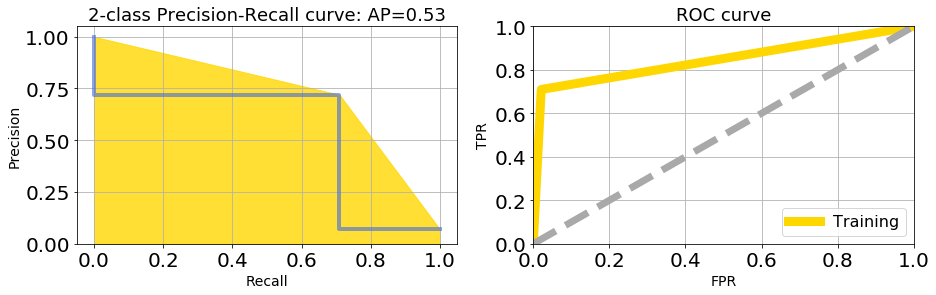

In [34]:
res # With outliers

,AUC,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1,db_size
Training,0.844,0.979,0.715,0.04,0.978,0.719,0.979,0.71,"(9543, 21980)"


In [29]:
res

,AUC,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1,db_size
Training,0.845,0.98,0.719,0.038,0.979,0.729,0.981,0.709,"(9998, 22326)"


### 9. Conclusion

The AUC score lowered as expected since more variance was added thanks to the data samples from the validation set. To compensate the class imbalance, I would have considered including more features pertaining to the minority class and even expand the set with a higher value for n-grams. Also if I had more free time to work on this project, I'd check out the option of finding Word2vecs that could be clustered in each class. 



---
## Part 3 – Short answer
As an insurance company, we collect premium on a monthly basis from customers. In return, we pay the customer’s veterinary bills should their pets receive medical treatment.
- How would you estimate the expected value of a customer at any given point in time?
- In what ways could we utilize this estimate?

Im assuming that the expected value is the expected value of loss for the company. In that view, a valuable customer affects with a minimal loss, that is: 
Cumulated premiums - Total amount in bills  (for any given point in time)

However when a new customer applies for insurance, its value can’t be determined by that formula. So in this case I would start with some biased value.  This bias will approximate to the correct prediction of a hypothetical loss. For that it should:

1. Predict the probability of the pet receiving medical treatment with high confidence. 
2. Predict whether the customer will/can pay the premiums on time and in its totality. 

That way I’d have an idea of the frequency and purpose of the medical assistance to calculate a hypothetical loss. 

In what ways could we utilize this estimate?

For starters, predicting the bias of a customer can reveal (with a clustering algorithm) aspects of different types of customer that can adjust to certain types of policies or insurance packages with different payment and medical assistance options that would steer the whole outcome into a minimal loss. 

In other words, understanding the customer's attributes, can help provide the adequate insurance. 

Moreover the temporal aspect of the value of the customer can give out patterns which can be useful as it encourages the insurance company to anticipate to high loss. 